In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
import albumentations.pytorch
import cv2
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from tqdm import tqdm

import wandb

config={
    "lr": 1.8e-4,
    "dropout": 0.5,
    "architecture": "efficientnet-b6 + 3way",
    "dataset": "vanilla + mask",
    "augmentation" : "None",
    "age_weightedloss" : [1.0, 1.0, 3.],
    "gender_weightedloss" : [1.5, 1.0],
    "gamma" : 0.8,
    "batch_size" : 32,
    "epochs" : 15,
    'model' : 'efficientnet-b6'
}

wandb.init(project="MaskClassification", name=config['model'], config=config)



wandb: Currently logged in as: youkind (use `wandb login --relogin` to force relogin)

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



In [2]:
print('CUDA GPU available : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')
device = torch.device("cuda")
CUDA_LAUNCH_BLOCKING=1

CUDA GPU available : True
1 GPU(s) is(are) allocated


In [3]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'
train_dir = '/opt/ml/input/data/train'

labels_to_class = {}
it = [(m, g, a) for m in [0,1,2] for g in [0, 1] for a in [0, 1, 2]]
for i, (m, g, a) in enumerate(it):
    labels_to_class[(m, g, a)] = i

## Dataset

In [4]:
class TrainDataset(Dataset):
    def __init__(self, train_dir, is_Train=True, transform=None):
        super().__init__()
        
        csv_path = os.path.join(train_dir, 'train.csv')
        csv = pd.read_csv(csv_path)
        self.image_dir = os.path.join(train_dir, 'images')
        self.transform = transform
        self.image_path = []
        path = csv['path']
        
        for p in path:
            images = [os.path.join(*[self.image_dir, p, image]) for image in os.listdir(os.path.join(self.image_dir, p)) if not image[:1] == '.']
            for image in images:
                self.image_path.append(image)

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_name = self.image_path[idx]
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        features = image_name.split('/')[-2:]
        
        masktoint = {'m' : 0, 'i' : 1, 'n' : 2}
        gendertoint = {'male' : 0, 'female' : 1}
        
        mask = masktoint[features[1][0]]
        age = int(features[0].split('_')[-1])
        gender = gendertoint[features[0].split('_')[1]]
        
        if age >= 58: # 원래 60
            age = 2
        elif age >= 30: # 원래 30
            age = 1
        else:
            age = 0        
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        return image, (mask, gender, age)

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = cv2.imread(self.img_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

    def __len__(self):
        return len(self.img_paths)

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import random_split

tfms = A.Compose([
        A.augmentations.crops.transforms.CenterCrop(400, 360, p=1.0),
        A.augmentations.geometric.resize.Resize(224, 224, interpolation=1, p=1),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.6),
        A.RandomBrightnessContrast(brightness_limit=0.1, p=0.6),
        A.GaussNoise(p=0.5),
        A.transforms.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), max_pixel_value=255.0, p=1.0),
        A.pytorch.transforms.ToTensorV2(),
    ])
tfms_test = A.Compose([
        A.augmentations.crops.transforms.CenterCrop(400, 360, p=1.0),
        A.augmentations.geometric.resize.Resize(224, 224, interpolation=1, p=1),
        A.transforms.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), max_pixel_value=255.0, p=1.0),
        A.pytorch.transforms.ToTensorV2(),
    ])
val_idx = []
person_idx = list(range(2700))

np.random.seed(211)
np.random.shuffle(person_idx)

n_val_person = int(2700 * 0.2)
val_person_idx = person_idx[:n_val_person]
train_indices = []
val_indices = []
for i in range(2700*15):
    if i // 15 not in val_person_idx:
        train_indices.append(i)
    else:
        val_indices.append(i)

# print(train_indices)
# print(val_indices)
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

dataset = TrainDataset(train_dir, transform=tfms)

# print(len(dataset))
# plt.imshow(np.array(train_dataset[312][0]['image'].permute(1,2,0)))

train_loader = DataLoader(dataset, batch_size=config['batch_size'], num_workers=4, pin_memory=True, sampler=train_indices)
val_loader = DataLoader(dataset, num_workers=4, batch_size=config['batch_size'], pin_memory=True, sampler=val_indices)

In [6]:
# plt.imshow(np.array(train_dataset[312][0]['image'].permute(1,2,0)))

## Model

In [7]:
from efficientnet_pytorch import EfficientNet

class Way3(nn.Module):
    def __init__(self):
        super().__init__()
#         self.convnet = timm.create_model(config['model'], pretrained=True, num_classes=512)
        self.convnet = EfficientNet.from_pretrained(config['model'], num_classes=512).to(device)
        self.mask = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )
        self.gender = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
        self.age = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )
        self.best_f1 = 0
        
    def forward(self, x):
        features = self.convnet(x)
        mask = self.mask(features)
        gender = self.gender(features)
        age = self.age(features)
        
        return mask, gender, age
    
model = Way3().to(device)

Loaded pretrained weights for efficientnet-b6


In [8]:
import torch.optim as optim 

gender_weight = torch.tensor(config["gender_weightedloss"])
age_weight = torch.tensor(config["age_weightedloss"])
                             
criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss(weight=gender_weight).to(device)
age_criterion = nn.CrossEntropyLoss(weight=age_weight).to(device)
# b_criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=config['gamma'], verbose=True)

Adjusting learning rate of group 0 to 1.8000e-04.


In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def check(loader, length, model):
    model.eval()
    val_loss = 0.0
    counter = 0
    y_true = []
    y_predicted = []

    m_acc = []
    g_acc = []
    a_acc = []
    with torch.no_grad():
        for (inputs, (m, g, a)) in loader:
            counter += 1
            
            for mask, gender, age in zip(m, g, a):
                answer = labels_to_class[(mask.item(), gender.item(), age.item())]
                y_true.append(answer)
            
            inputs = inputs.to(device=device)
            m = m.to(device)
            g = g.to(device)
            a = a.to(device)

            m_pred, g_pred, a_pred = model(inputs)
    
            m_loss = criterion(m_pred, m)
            g_loss = gender_criterion(g_pred, g)
            a_loss = age_criterion(a_pred, a) # data imbalance
            
            loss = (g_loss+a_loss+m_loss)
            
            val_loss += loss.item()
            
            m_argmax = m_pred.detach().cpu().numpy().argmax(1)
            g_argmax = g_pred.detach().cpu().numpy().argmax(1)
            a_argmax = a_pred.detach().cpu().numpy().argmax(1)

            m_acc.append(accuracy_score(m_argmax, m.detach().cpu().numpy()))
            g_acc.append(accuracy_score(g_argmax, g.detach().cpu().numpy()))
            a_acc.append(accuracy_score(a_argmax, a.detach().cpu().numpy()))

            for mask, gender, age in zip(m_argmax, g_argmax, a_argmax):
                predicted = labels_to_class[(mask.item(), gender.item(), age.item())]
                y_predicted.append(predicted)
    
    
    cm = confusion_matrix(y_true, y_predicted)
    F1 = []
    for c in range(18):
        precision = cm[c][c] / np.sum(cm, axis=0)[c]
        recall = cm[c][c] / np.sum(cm, axis=1)[c]
        F1.append(2 * precision * recall / (precision + recall))
    macro_F1 = np.mean(F1)

    s = 0
    for c in range(18):
        s += cm[c][c]
        
    print("< VALIDATION >")
    print("*"*73)
    print("Validation Loss :", val_loss/counter)
    print("-"*73)
    print("Total Accuracy")
    print(accuracy_score(y_true, y_predicted) * 100, "%")
    print("-"*73)
    print("Class Accuracy")
    print("Mask   :", np.mean(m_acc)*100, "%")
    print("Gender :", np.mean(g_acc)*100, "%")
    print("Age    :", np.mean(a_acc)*100, "%")
    print("-"*73)
    print("Confusion Matrix")
    for row in cm:
        for c in row:
            print(str(c).ljust(4), end='')
        print()
    print("-"*73)
    print("Validation F1 score :" , macro_F1)
    for c, f in enumerate(F1):
        print("Class", c, ":", f)
        
    if model.best_f1 < macro_F1:
        model.best_f1 = macro_F1
        torch.save(model.state_dict(), '/opt/ml/weights/3way/{}/{:.4f}.pt'.format(config['model'], model.best_f1))
        print("model saved!")
    print("*"*73)
    print()
    wandb.log({
        "Validation Loss" : val_loss/counter, 
        "Validation Total Accuracy" :accuracy_score(y_true, y_predicted) * 100, 
        "Validation F1" : macro_F1,
        "Mask Accuracy" : np.mean(m_acc)*100,
        "Gender Accuracy" : np.mean(g_acc)*100,
        "Age Accuracy" : np.mean(a_acc)*100,
        "Mask Loss" : m_loss.item(),
        "Gender Loss" : g_loss.item(),
        "Age Loss" : a_loss.item(),
    })
        
    model.train()

In [10]:

folder = '/opt/ml/weights/3way/{}'.format(config['model'])
if not os.path.exists(folder):
    os.mkdir(folder)

for epoch in range(config['epochs']):
    print("Epoch :", epoch + 1)
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    total_it = int(len(train_indices)/train_loader.batch_size)
    prog_bar = tqdm(enumerate(train_loader), total=total_it)
    for i, (inputs, (m, g, a)) in prog_bar:
        
        counter += 1
        optimizer.zero_grad()
        inputs = inputs.to(device)
        m_pred, g_pred, a_pred = model(inputs)
        
        
        m = m.to(device)
        g = g.to(device)
        a = a.to(device)
        total += m.size(0)
        
        
        m_loss = criterion(m_pred, m)
        g_loss = gender_criterion(g_pred, g)
        a_loss = age_criterion(a_pred, a) # data imbalance 
        
        
        loss = (g_loss+a_loss+m_loss)
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        
        if i == total_it//2 or i == total_it-1:
            train_loss = train_running_loss / counter

            print("Train Loss :", train_loss)
            wandb.log({"Train Loss" : train_loss})
            
            check(val_loader, len(val_indices), model)
    scheduler.step()
    train_running_loss = 0.0
    train_running_correct = 0
print("Finish")

Epoch : 1


 50%|█████     | 506/1012 [03:37<03:36,  2.33it/s]

Train Loss : 1.846778157900071
< VALIDATION >
*************************************************************************
Validation Loss : 1.6809449421139213
-------------------------------------------------------------------------
Total Accuracy
75.35802469135803 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 98.96653543307087 %
Gender : 96.14911417322834 %
Age    : 78.62942913385827 %
-------------------------------------------------------------------------
Confusion Matrix
471 0   0   9   0   0   2   0   0   0   0   0   3   0   0   0   0   0   
64  129 102 4   13  1   0   0   2   0   0   0   0   0   0   0   0   0   
2   36  145 0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   
17  0   0   731 28  0   0   0   0   4   0   0   0   0   0   0   0   0   
11  6   2   70  514 84  0   0   0   1   1   1   0   0   0   0   0   0   
0   0   2   0   117 124 0   0   0   0   0   2   0   0   0   0   0   0   
6   0   0   0   0   0   469 5

 50%|█████     | 507/1012 [04:04<1:11:14,  8.47s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [07:39<00:00,  2.36it/s] 

Train Loss : 1.732773920646298
< VALIDATION >
*************************************************************************
Validation Loss : 1.6687829100240872
-------------------------------------------------------------------------
Total Accuracy
77.09876543209877 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 98.91732283464567 %
Gender : 97.08415354330708 %
Age    : 80.25344488188976 %
-------------------------------------------------------------------------
Confusion Matrix
448 9   0   21  1   0   6   0   0   0   0   0   0   0   0   0   0   0   
41  199 38  4   27  4   1   1   0   0   0   0   0   0   0   0   0   0   
0   59  121 0   2   3   0   0   0   0   0   0   0   0   0   0   0   0   
8   0   0   747 23  1   0   0   0   1   0   0   0   0   0   0   0   0   
1   1   0   65  434 184 0   0   0   0   3   1   0   0   0   0   0   1   
0   0   0   0   72  163 0   0   0   0   0   2   0   0   0   0   0   8   
0   0   0   0   0   0   463 8

100%|██████████| 1012/1012 [08:06<00:00,  8.40s/it]

model saved!
*************************************************************************



1013it [08:06,  2.08it/s]                          

Adjusting learning rate of group 0 to 1.4400e-04.
Epoch : 2



 50%|█████     | 506/1012 [03:36<03:35,  2.35it/s]

Train Loss : 1.5665525181523912
< VALIDATION >
*************************************************************************
Validation Loss : 1.662892684223145
-------------------------------------------------------------------------
Total Accuracy
79.49382716049382 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.55708661417323 %
Gender : 97.17027559055119 %
Age    : 81.92667322834646 %
-------------------------------------------------------------------------
Confusion Matrix
469 12  0   1   2   0   1   0   0   0   0   0   0   0   0   0   0   0   
41  213 51  1   9   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   60  124 0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
16  1   0   730 32  0   0   0   0   1   0   0   0   0   0   0   0   0   
8   20  5   48  538 68  0   0   0   0   2   1   0   0   0   0   0   0   
0   2   4   0   133 102 0   0   0   0   1   3   0   0   0   0   0   0   
0   0   0   0   0   0   485 0

 50%|█████     | 507/1012 [04:03<1:10:55,  8.43s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [07:39<00:00,  2.36it/s] 

Train Loss : 1.5529250599178872


100%|██████████| 1012/1012 [08:05<00:00,  8.31s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 1.668270755940535
-------------------------------------------------------------------------
Total Accuracy
76.0 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.66781496062993 %
Gender : 97.94537401574803 %
Age    : 77.59596456692913 %
-------------------------------------------------------------------------
Confusion Matrix
470 10  0   1   1   0   3   0   0   0   0   0   0   0   0   0   0   0   
37  143 121 0   8   6   0   0   0   0   0   0   0   0   0   0   0   0   
1   44  134 0   0   5   0   0   1   0   0   0   0   0   0   0   0   0   
18  3   0   683 73  1   0   0   0   2   0   0   0   0   0   0   0   0   
3   2   2   28  453 199 1   0   0   0   2   0   0   0   0   0   0   0   
0   0   0   0   72  170 0   0   0   0   0   2   0   0   0   0   0   1   
0   0   0   0   0   0   476 6   0   3   0   0   0   0   0   0   0   0   
0

1013it [08:06,  2.08it/s]                          

Adjusting learning rate of group 0 to 1.1520e-04.
Epoch : 3



 50%|█████     | 506/1012 [03:36<03:36,  2.34it/s]

Train Loss : 1.5196764589061398


 50%|█████     | 507/1012 [04:03<1:10:06,  8.33s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 1.649286384657612
-------------------------------------------------------------------------
Total Accuracy
77.34567901234568 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.53248031496062 %
Gender : 97.81003937007874 %
Age    : 79.34301181102363 %
-------------------------------------------------------------------------
Confusion Matrix
467 10  0   4   1   0   3   0   0   0   0   0   0   0   0   0   0   0   
45  142 112 4   11  1   0   0   0   0   0   0   0   0   0   0   0   0   
1   39  144 0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   
14  1   0   720 39  2   0   0   0   4   0   0   0   0   0   0   0   0   
0   13  4   46  437 185 0   0   0   0   4   1   0   0   0   0   0   0   
0   2   0   0   65  176 0   0   0   0   0   1   0   0   0   0   0   1   
0   0   0   0   0   0   480 5   0   0   0   0   0   0   0   0

100%|█████████▉| 1011/1012 [07:38<00:00,  2.35it/s] 

Train Loss : 1.5067285564341564
< VALIDATION >
*************************************************************************
Validation Loss : 1.6518847088175497
-------------------------------------------------------------------------
Total Accuracy
80.14814814814815 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.44635826771653 %
Gender : 98.09301181102363 %
Age    : 82.19734251968504 %
-------------------------------------------------------------------------
Confusion Matrix
455 29  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
30  209 64  2   8   1   0   1   0   0   0   0   0   0   0   0   0   0   
1   69  112 0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   
23  4   0   720 33  0   0   0   0   0   0   0   0   0   0   0   0   0   
6   6   1   47  492 136 0   0   0   0   1   1   0   0   0   0   0   0   
0   0   0   0   89  153 0   0   0   0   0   2   0   0   0   0   0   1   
0   0   0   0   0   0   457 

100%|██████████| 1012/1012 [08:06<00:00,  8.46s/it]

model saved!
*************************************************************************



1013it [08:06,  2.08it/s]                          

Adjusting learning rate of group 0 to 9.2160e-05.
Epoch : 4



 50%|█████     | 506/1012 [03:36<03:35,  2.34it/s]

Train Loss : 1.4853251878561589


 50%|█████     | 507/1012 [04:03<1:10:24,  8.37s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 1.6550605484819787
-------------------------------------------------------------------------
Total Accuracy
80.51851851851852 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.65551181102363 %
Gender : 97.79773622047244 %
Age    : 82.57874015748031 %
-------------------------------------------------------------------------
Confusion Matrix
474 9   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   
34  182 90  0   7   1   0   0   1   0   0   0   0   0   0   0   0   0   
0   52  132 0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   
25  0   0   724 30  0   0   0   0   1   0   0   0   0   0   0   0   0   
4   6   6   33  572 66  0   0   0   0   2   1   0   0   0   0   0   0   
0   0   0   0   138 104 0   0   0   0   1   2   0   0   0   0   0   0   
0   0   0   0   0   0   474 11  0   0   0   0   0   0   0   

100%|█████████▉| 1011/1012 [07:38<00:00,  2.27it/s] 

Train Loss : 1.478020049013168


100%|██████████| 1012/1012 [08:05<00:00,  8.27s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 1.643732907734518
-------------------------------------------------------------------------
Total Accuracy
79.45679012345678 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.80314960629921 %
Gender : 97.82234251968504 %
Age    : 81.39763779527559 %
-------------------------------------------------------------------------
Confusion Matrix
472 9   1   0   0   1   2   0   0   0   0   0   0   0   0   0   0   0   
39  125 132 0   15  4   0   0   0   0   0   0   0   0   0   0   0   0   
1   35  141 0   0   8   0   0   0   0   0   0   0   0   0   0   0   0   
16  2   0   688 73  0   0   0   0   1   0   0   0   0   0   0   0   0   
2   2   1   19  507 156 0   0   0   0   3   0   0   0   0   0   0   0   
0   0   0   0   74  170 0   0   0   0   0   1   0   0   0   0   0   0   
0   0   0   0   0   0   466 17  0   1   1   0   0   0   0   0

1013it [08:05,  2.09it/s]                          

Adjusting learning rate of group 0 to 7.3728e-05.
Epoch : 5



 50%|█████     | 506/1012 [03:36<03:37,  2.33it/s]

Train Loss : 1.461820336723704
< VALIDATION >
*************************************************************************
Validation Loss : 1.6367931600630752
-------------------------------------------------------------------------
Total Accuracy
82.45679012345678 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.61860236220473 %
Gender : 98.06840551181102 %
Age    : 84.4119094488189 %
-------------------------------------------------------------------------
Confusion Matrix
469 9   0   2   0   0   5   0   0   0   0   0   0   0   0   0   0   0   
34  225 44  0   12  0   0   0   0   0   0   0   0   0   0   0   0   0   
0   64  116 0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   
18  0   0   712 46  1   0   0   0   3   0   0   0   0   0   0   0   0   
3   5   0   28  546 106 1   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   91  153 0   0   0   0   0   1   0   0   0   0   0   0   
0   0   0   0   0   0   473 6 

 50%|█████     | 507/1012 [04:04<1:11:42,  8.52s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [07:39<00:00,  2.36it/s] 

Train Loss : 1.457197913657064


100%|██████████| 1012/1012 [08:06<00:00,  8.23s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 1.647428200939509
-------------------------------------------------------------------------
Total Accuracy
82.18518518518519 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.86466535433071 %
Gender : 98.04379921259843 %
Age    : 84.09202755905511 %
-------------------------------------------------------------------------
Confusion Matrix
475 8   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
35  225 43  0   11  1   0   0   0   0   0   0   0   0   0   0   0   0   
0   84  97  0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   
18  1   0   704 56  0   0   0   0   1   0   0   0   0   0   0   0   0   
1   11  0   29  559 88  0   0   0   0   1   1   0   0   0   0   0   0   
0   1   0   0   103 139 0   0   0   0   0   2   0   0   0   0   0   0   
0   0   0   0   0   0   479 6   0   0   0   0   0   0   0   0

1013it [08:06,  2.08it/s]                          

Adjusting learning rate of group 0 to 5.8982e-05.
Epoch : 6



 50%|█████     | 506/1012 [03:36<03:34,  2.36it/s]

Train Loss : 1.4476487702401668


 50%|█████     | 507/1012 [04:02<1:09:48,  8.29s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 1.6536983265651493
-------------------------------------------------------------------------
Total Accuracy
81.09876543209876 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.66781496062993 %
Gender : 97.83464566929135 %
Age    : 83.05856299212599 %
-------------------------------------------------------------------------
Confusion Matrix
467 10  0   3   2   0   3   0   0   0   0   0   0   0   0   0   0   0   
38  198 56  2   16  4   0   0   0   0   1   0   0   0   0   0   0   0   
1   61  116 0   0   7   0   0   0   0   0   0   0   0   0   0   0   0   
16  0   0   720 42  0   0   0   0   2   0   0   0   0   0   0   0   0   
5   1   2   33  502 142 0   0   0   0   4   1   0   0   0   0   0   0   
0   0   1   0   89  152 0   0   0   0   0   3   0   0   0   0   0   0   
0   0   0   0   0   0   464 19  0   0   2   0   0   0   0   

100%|█████████▉| 1011/1012 [07:37<00:00,  2.37it/s] 

Train Loss : 1.445326972738085


100%|██████████| 1012/1012 [08:03<00:00,  8.16s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 1.6418551891807496
-------------------------------------------------------------------------
Total Accuracy
80.72839506172839 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9138779527559 %
Gender : 97.79773622047244 %
Age    : 82.7632874015748 %
-------------------------------------------------------------------------
Confusion Matrix
470 12  0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
34  226 42  0   11  2   0   0   0   0   0   0   0   0   0   0   0   0   
1   77  103 0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   
15  0   0   728 36  0   0   0   0   1   0   0   0   0   0   0   0   0   
4   10  0   34  471 170 0   0   0   0   0   1   0   0   0   0   0   0   
0   0   0   0   75  170 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   473 9   0   3   0   0   0   0   0   0 

1013it [08:04,  2.09it/s]                          

Adjusting learning rate of group 0 to 4.7186e-05.
Epoch : 7



 50%|█████     | 506/1012 [03:36<03:34,  2.36it/s]

Train Loss : 1.4413034405698908


 50%|█████     | 507/1012 [04:02<1:09:31,  8.26s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 1.6436237509795062
-------------------------------------------------------------------------
Total Accuracy
81.20987654320987 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9015748031496 %
Gender : 98.06840551181102 %
Age    : 82.96013779527559 %
-------------------------------------------------------------------------
Confusion Matrix
472 8   0   2   2   0   1   0   0   0   0   0   0   0   0   0   0   0   
38  227 36  0   11  3   0   0   0   0   0   0   0   0   0   0   0   0   
0   73  107 0   1   4   0   0   0   0   0   0   0   0   0   0   0   0   
18  0   0   730 31  0   0   0   0   1   0   0   0   0   0   0   0   0   
3   5   0   38  458 185 0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   70  175 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   481 2   0   2   0   0   0   0   0   0

100%|█████████▉| 1011/1012 [07:37<00:00,  2.35it/s] 

Train Loss : 1.4395360503743289


100%|██████████| 1012/1012 [08:04<00:00,  8.28s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 1.6416086526367608
-------------------------------------------------------------------------
Total Accuracy
81.8395061728395 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.81545275590551 %
Gender : 98.25295275590551 %
Age    : 83.51377952755905 %
-------------------------------------------------------------------------
Confusion Matrix
474 9   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
39  221 41  0   10  4   0   0   0   0   0   0   0   0   0   0   0   0   
1   77  105 0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   
15  0   0   733 30  0   0   0   0   2   0   0   0   0   0   0   0   0   
4   6   0   41  501 137 0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   82  162 0   0   0   0   0   1   0   0   0   0   0   0   
0   0   0   0   0   0   472 10  0   3   0   0   0   0   0   0

1013it [08:04,  2.09it/s]                          

Adjusting learning rate of group 0 to 3.7749e-05.
Epoch : 8



 50%|█████     | 506/1012 [03:36<03:35,  2.34it/s]

Train Loss : 1.4369904037998509


 50%|█████     | 507/1012 [04:03<1:09:46,  8.29s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 1.628229462724971
-------------------------------------------------------------------------
Total Accuracy
81.4074074074074 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.79084645669292 %
Gender : 98.27755905511812 %
Age    : 83.15698818897637 %
-------------------------------------------------------------------------
Confusion Matrix
472 13  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
37  209 58  0   10  1   0   0   0   0   0   0   0   0   0   0   0   0   
1   50  132 0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   
11  2   0   731 35  1   0   0   0   0   0   0   0   0   0   0   0   0   
2   6   0   31  488 162 0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   72  173 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   468 16  0   0   1   0   0   0   0   0 

100%|█████████▉| 1011/1012 [07:38<00:00,  2.36it/s] 

Train Loss : 1.4349272626897562


100%|██████████| 1012/1012 [08:05<00:00,  8.31s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 1.6410955232898081
-------------------------------------------------------------------------
Total Accuracy
81.44444444444444 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.82775590551181 %
Gender : 98.14222440944881 %
Age    : 83.24311023622047 %
-------------------------------------------------------------------------
Confusion Matrix
468 16  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
33  224 45  0   11  1   0   0   0   0   1   0   0   0   0   0   0   0   
0   64  117 0   1   3   0   0   0   0   0   0   0   0   0   0   0   0   
19  0   0   725 35  1   0   0   0   0   0   0   0   0   0   0   0   0   
4   6   0   30  484 164 0   0   0   0   1   1   0   0   0   0   0   0   
0   0   0   0   79  166 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   464 20  0   1   0   0   0   0   0   

1013it [08:05,  2.09it/s]                          

Adjusting learning rate of group 0 to 3.0199e-05.
Epoch : 9



  4%|▍         | 39/1012 [00:17<07:07,  2.28it/s]


KeyboardInterrupt: 

## Testing

In [16]:
model.load_state_dict(torch.load('/opt/ml/weights/3way/{}/{:.4f}.pt'.format(config['model'], model.best_f1))), model.best_f1
# model.load_state_dict(torch.load('/opt/ml/weights/3way/{}/0.9602.pt'.format(config['model'])))

(<All keys matched successfully>, 0.7741065247182025)

In [15]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
dataset = TestDataset(image_paths, tfms_test)

loader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=64,
    num_workers=4
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
# device = torch.device('cuda')

model.eval()
device = torch.device("cuda:0")
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []

prog_bar = tqdm(enumerate(loader), total=int(len(dataset)/loader.batch_size))
for i, images in prog_bar:
    with torch.no_grad():
        images = images.to(device)
        m_pred, g_pred, a_pred = model(images)
#         print(images.shape)
#         print(m_pred.shape)
        m_argmax = m_pred.detach().cpu().numpy().argmax(1)
        g_argmax = g_pred.detach().cpu().numpy().argmax(1)
        a_argmax = a_pred.detach().cpu().numpy().argmax(1)
        
        for mask, gender, age in zip(m_argmax, g_argmax, a_argmax):
            predicted = labels_to_class[(mask.item(), gender.item(), age.item())]
            all_predictions.append(predicted)
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

197it [00:38,  5.18it/s]                         

test inference is done!


Normal : 80.48307299613953 %
Female : 70.16461491584778 %
~ 30 : 99.12283420562744 %


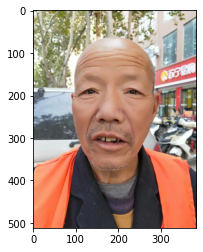

In [14]:
idx = 3
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

image = cv2.imread(image_paths[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

image = tfms_test(image=image)['image'].to(device)
image = image.unsqueeze(0)
m_pred, g_pred, a_pred = model(image)

m_argmax = m_pred.detach().cpu().numpy().argmax(1)
g_argmax = g_pred.detach().cpu().numpy().argmax(1)
a_argmax = a_pred.detach().cpu().numpy().argmax(1)

#
masklabel = {0: "Mask", 1: "Incorrect", 2: "Normal"}
genderlabel = {0: "Male", 1: "Female"}
agelabel = {0: "~ 30", 1: "30 ~ 60", 2: "60 ~"}
#
print(masklabel[m_argmax[0]]+ " :", (m_pred[0][m_argmax].item())*100, '%')
print(genderlabel[g_argmax[0]]+ " :", (g_pred[0][g_argmax].item())*100, '%')
print(agelabel[a_argmax[0]]+ " :", (a_pred[0][a_argmax].item())*100, '%')
